In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import metapack as mp
from pathlib import Path
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.regression.linear_model import OLS
import seaborn as sns

%run ./lib.py

In [2]:
df = pd.read_csv('scf16.csv')

df.head()

df['race'] = df.race.astype('category')


In [3]:
# Get the extract and pull out a few more variables
#scfe = pkg.reference('scf_extract').dataframe().rename(columns={'Y1': 'record_id'})
#scfe.columns = [c.lower() for c in scfe.columns]
#df = df.merge(scfe, on='record_id', suffixes=('','_other') )


In [4]:
dfs = make_sample(df, N=100_000, extra_cols=['occ','occ_1', 'nincpctlecat','nwpctlecat', 'racecl','debt', 'spend_exceeds', 'saved', 'lt_planner', 'homeeq', 'debt2inc'])
dfs.head()

,case_id,record_id,race,age_1,agecl,norminc,networth,asset,gi_sum,occat1,...,nwpctlecat,racecl,debt,spend_exceeds,saved,lt_planner,homeeq,debt2inc,income_decile,gi_sum_decile
17553,3518,35184,white,59,4,73922.458357,833500.0,833500.0,310000,3,...,9,1,0.0,2,0,1,0.0,0.000000,6,8.0
30775,6168,61681,black,57,4,17214.819070,200.0,200.0,0,3,...,2,2,0.0,3,1,0,0.0,0.000000,0,0.0
21029,4216,42165,black,39,2,31391.728891,-69090.0,110230.0,0,1,...,1,2,179320.0,1,0,0,15000.0,5.712333,2,0.0
0,1,11,white,71,5,13164.273406,176720.0,177100.0,0,3,...,7,1,380.0,2,0,1,150000.0,0.028866,0,0.0
22009,4412,44125,white,48,3,354422.745549,900020.0,1193450.0,0,2,...,9,2,293430.0,2,0,1,263000.0,2.318147,9,0.0


In [5]:

# Create quantiles for gi_sum
o, gi_sum_bins = pd.qcut(dfs[dfs.gi_sum > 0].gi_sum, 10 , retbins = True)
gi_sum_bins[0] = 0 # So zero gets included in a bin
dfs['gi_sum_decile']  = pd.cut(dfs.gi_sum, gi_sum_bins, labels=False).fillna(0)

family structure: 
* 1=not married/LWP + children, 
* 2=not married/LWP + no children + head under 55, 
* 3=not married/LWP + no children + head 55 or older, 
* 4=married/LWP + children
* 5=married/LWP + no children;

In [6]:
t=dfs.groupby(['occ_1','race']).norminc.count().to_frame().reset_index()
pd.crosstab(t.occ_1 ,t.race, t.norminc, aggfunc=np.sum, margins=True, normalize='index')

race,black,hisp,other,white
occ_1,,,,
0,0.170360,0.081357,0.040843,0.707440
1,0.126639,0.073332,0.069384,0.730644
2,0.193640,0.119194,0.046933,0.640233
3,0.223245,0.187644,0.035491,0.553620
4,0.083161,0.214915,0.024459,0.677465
5,0.207802,0.159040,0.034059,0.599100
6,0.068230,0.196162,0.022388,0.713220
All,0.159180,0.112000,0.047070,0.681750


In [7]:
dfs[dfs.nincpctlecat <=10].groupby('occ_1').norminc.median()

occ_1
0    35442.274555
1    84048.822516
2    53669.730040
3    40505.456634
4    58732.912119
5    51644.457209
6    50631.820793
Name: norminc, dtype: float64

In [8]:
dfs[dfs.nincpctlecat <=10].groupby(['occ','agecl']).norminc.median().unstack().T.round(0)

occ,1,2,3,4,5,6,7
agecl,,,,,,,
1,62783.0,39493.0,35442.0,35442.0,32404.0,27341.0,18227.0
2,89112.0,60758.0,40505.0,46581.0,48607.0,34430.0,23291.0
3,97213.0,58227.0,40505.0,45569.0,45569.0,42531.0,21265.0
4,94175.0,61771.0,35442.0,60758.0,51644.0,55695.0,24303.0
5,91137.0,69872.0,35442.0,70885.0,42531.0,46814.0,39493.0
6,76282.0,45569.0,41062.0,45569.0,42531.0,32404.0,36455.0


In [9]:
dfs[dfs.nincpctlecat <=10].groupby(['famstruct','nincpctlecat']).networth.median().unstack().T

famstruct,1,2,3,4,5
nincpctlecat,,,,,
1,5010.0,350.0,7851.0,4460.0,13450.0
2,4890.0,2900.0,54415.0,9500.0,34550.0
3,11351.0,7100.0,104300.0,14110.0,79700.0
4,20800.0,12300.0,151000.0,18200.0,76000.0
5,37310.0,35575.0,252000.0,33090.0,124200.0
6,85400.0,51450.0,317400.0,65900.0,149800.0
7,112600.0,98250.0,344800.0,89980.0,224600.0
8,149010.0,162000.0,487000.0,137500.0,290630.0
9,294900.0,305901.0,799600.0,304900.0,561450.0


In [10]:
t.loc[:, t.dtypes ==  pd.core.arrays.integer.Int64Dtype].columns

Index([], dtype='object')

In [11]:
t = dfs.dropna().copy()

t = t[t.nwpctlecat <=10 ]

for c in dfs.loc[:, dfs.dtypes == np.float64].columns:
    t[c] = t[c].astype(float)

for c in  t.loc[:, t.dtypes ==  pd.core.arrays.integer.Int64Dtype].columns:
    try:
        t[c] = t[c].astype(int)
    except:
        pass

# Why are these not caught by the prior conversions?
for c in ['agecl', 'housecl', 'famstruct', 'indcat', 'edcl', 'occ', 'nwpctlecat', 'racecl']:
    t[c] = t[c].astype(int)
 
t['debt_ihs'] = np.arcsinh(t.debt)
t['asset_ihs'] = np.arcsinh(t.asset)
t['networth_ihs'] = np.arcsinh(t.networth)
t['norminc_ihs'] = np.arcsinh(t.norminc)
t['gi_sum_ihs'] = np.arcsinh(t.gi_sum.astype(float))

t['nwrank'] = t.networth.rank().astype(int)
t['nincrank'] = t.norminc.rank().astype(int)
t['girank'] = t.gi_sum.rank()

regr = t # [t.networth > 0] # t[(t.agecl==3) & (t.housecl==1) & (t.famstruct==4)]

regr.to_csv('regression_set.csv')

m = ols('asset_ihs ~ norminc_ihs + gi_sum_ihs + C(racecl) + C(agecl) + C(housecl) + C(famstruct) + C(edcl) + C(occ) ',
        data=regr).fit()

m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              asset_ihs   R-squared:                       0.640
Model:                            OLS   Adj. R-squared:                  0.640
Method:                 Least Squares   F-statistic:                     7675.
Date:                Thu, 13 Aug 2020   Prob (F-statistic):               0.00
Time:                        14:51:01   Log-Likelihood:            -1.7223e+05
No. Observations:               95097   AIC:                         3.445e+05
Df Residuals:                   95074   BIC:                         3.447e+05
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             3.8371      0.083     45.979      0.000       3.674       4.001
C(racecl)[T.2]       -0.2866      0.011    -26.710      0.000      -0.308      -0.266
C(agecl)[T.2]         0.0745      0.016      4.599      0.000       0.043       0.106
C(agecl)[T.3]         0.2575      0.016     15.995      0.000       0.226       0.289
C(agecl)[T.4]         0.4518      0.018     24.801      0.000       0.416       0.488
C(agecl)[T.5]         0.7896      0.022     36.695      0.000       0.747       0.832
C(agecl)[T.6]         1.0621      0.024     44.317      0.000       1.015       1.109
C(housecl)[T.2]      -2.5664      0.012   -218.787      0.000      -2.589      -2.543
C(famstruct)[T.2]     0.0855      0.019      4.451      0.000       0.048       0.123
C(famstruct)[T.3]    -0.0976      0.020     -4.788      0.000      -0.138      -0.058
C(famstruct)[T.4]     0.2540      0.017     14.750      0.000       0.220       0.288
C(famstruct)[T.5]     0.1292      0.018      7.233      0.000       0.094       0.164
C(edcl)[T.2]          0.4465      0.017     26.746      0.000       0.414       0.479
C(edcl)[T.3]          0.6593      0.017     38.621      0.000       0.626       0.693
C(edcl)[T.4]          0.9398      0.018     51.156      0.000       0.904       0.976
C(occ)[T.2]          -0.2025      0.015    -13.207      0.000      -0.233      -0.172
C(occ)[T.3]          -0.2393      0.019    -12.713      0.000      -0.276      -0.202
C(occ)[T.4]          -0.3384      0.023    -14.709      0.000      -0.383      -0.293
C(occ)[T.5]          -0.3700      0.025    -14.822      0.000      -0.419      -0.321
C(occ)[T.6]           0.2296      0.063      3.629      0.000       0.106       0.354
C(occ)[T.7]          -0.6678      0.016    -40.692      0.000      -0.700      -0.636
norminc_ihs           0.7283      0.007    101.767      0.000       0.714       0.742
gi_sum_ihs            0.0333      0.001     29.882      0.000       0.031       0.036
==============================================================================
Omnibus:                    48951.081   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           719947.433
Skew:                          -2.134   Prob(JB):                         0.00
Kurtosis:                      15.786   Cond. No.                         210.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [12]:
dfs[(dfs.nincpctlecat<=9)&(dfs.spend_exceeds==3)].groupby(['occ','race']).norminc.mean().unstack()

race,black,hisp,other,white
occ,,,,
1,80242.544004,82070.348462,88696.812880,90303.907224
2,60170.469246,60907.885537,53733.747285,73697.520475
3,46083.756184,42129.244490,60083.094007,53242.799796
4,50393.851235,49630.171390,42696.433607,63422.990313
5,64176.450316,50242.345248,45473.106976,57136.973441
6,NaN,26328.546812,151895.462378,73244.166551
7,36330.032079,35821.208780,61107.921682,53561.943566


In [13]:
dfs[dfs.nincpctlecat<=10].groupby(['lt_planner','nincpctlecat']).networth.median().unstack().T

lt_planner,0,1
nincpctlecat,,
1,2800.0,5500.0
2,6350.0,28070.0
3,18290.0,38700.0
4,19320.0,49400.0
5,39820.0,115000.0
6,80900.0,103100.0
7,64070.0,199330.0
8,152600.0,200870.0
9,274120.0,440200.0


# Blinder-Oaxaca Decomposition

In [14]:
'C(race) + C(agecl) + C(housecl) + C(famstruct) + C(edcl) + C(occ) '

dep_col = 'asset_ihs'
ob_cols = ['norminc_ihs', 'gi_sum_ihs', 'racecl']

t = regr.copy()
t['racecl'] = (t.racecl-1).astype('uint8')

for c in 'agecl housecl famstruct edcl occ'.split():
    t[c] = t[c].astype('category')
    ob_cols.append(c)


y = t[dep_col]
X = pd.get_dummies(t[ob_cols])
X = sm.add_constant(X)
X.head()

/Users/eric/opt/anaconda3/envs/data/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


,const,norminc_ihs,gi_sum_ihs,racecl,agecl_1,agecl_2,agecl_3,agecl_4,agecl_5,agecl_6,...,edcl_2,edcl_3,edcl_4,occ_1,occ_2,occ_3,occ_4,occ_5,occ_6,occ_7
17553,1.0,11.903919,13.337475,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
30775,1.0,10.446673,0.000000,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
21029,1.0,11.047447,0.000000,1,0,1,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
0,1.0,10.178409,0.000000,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
22009,1.0,13.471393,0.000000,1,0,0,1,0,0,0,...,0,1,0,1,0,0,0,0,0,0


In [15]:
m = OLS(y, X).fit()
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              asset_ihs   R-squared:                       0.640
Model:                            OLS   Adj. R-squared:                  0.640
Method:                 Least Squares   F-statistic:                     7675.
Date:                Thu, 13 Aug 2020   Prob (F-statistic):               0.00
Time:                        14:51:01   Log-Likelihood:            -1.7223e+05
No. Observations:               95097   AIC:                         3.445e+05
Df Residuals:                   95074   BIC:                         3.447e+05
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.4835      0.036     40.973      0.000       1.412       1.554
norminc_ihs     0.7283      0.007    101.767      0.000       0.714       0.742
gi_sum_ihs      0.0333      0.001     29.882      0.000       0.031       0.036
racecl         -0.2866      0.011    -26.710      0.000      -0.308      -0.266
agecl_1        -0.1920      0.013    -15.108      0.000      -0.217      -0.167
agecl_2        -0.1175      0.014     -8.491      0.000      -0.145      -0.090
agecl_3         0.0655      0.013      4.891      0.000       0.039       0.092
agecl_4         0.2598      0.012     20.807      0.000       0.235       0.284
agecl_5         0.5976      0.015     39.849      0.000       0.568       0.627
agecl_6         0.8701      0.017     50.543      0.000       0.836       0.904
housecl_1       2.0249      0.020    100.932      0.000       1.986       2.064
housecl_2      -0.5415      0.018    -30.187      0.000      -0.577      -0.506
famstruct_1     0.2225      0.014     16.246      0.000       0.196       0.249
famstruct_2     0.3079      0.014     22.452      0.000       0.281       0.335
famstruct_3     0.1249      0.014      8.784      0.000       0.097       0.153
famstruct_4     0.4765      0.014     34.721      0.000       0.450       0.503
famstruct_5     0.3517      0.013     26.457      0.000       0.326       0.378
edcl_1         -0.1405      0.013    -10.612      0.000      -0.166      -0.115
edcl_2          0.3060      0.012     25.950      0.000       0.283       0.329
edcl_3          0.5187      0.013     41.234      0.000       0.494       0.543
edcl_4          0.7993      0.015     54.157      0.000       0.770       0.828
occ_1           0.4388      0.015     29.372      0.000       0.410       0.468
occ_2           0.2363      0.016     14.894      0.000       0.205       0.267
occ_3           0.1995      0.018     11.361      0.000       0.165       0.234
occ_4           0.1005      0.021      4.712      0.000       0.059       0.142
occ_5           0.0689      0.023      3.053      0.002       0.025       0.113
occ_6           0.6685      0.054     12.292      0.000       0.562       0.775
occ_7          -0.2290      0.014    -15.810      0.000      -0.257      -0.201
==============================================================================
Omnibus:                    48951.081   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           719947.433
Skew:                          -2.134   Prob(JB):                         0.00
Kurtosis:                      15.786   Cond. No.                     1.25e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalu

In [16]:
import statsmodels.api as sm
from statsmodels.stats.oaxaca import OaxacaBlinder

model = OaxacaBlinder(y, X, 'racecl', hasconst = True)
model.two_fold().summary()

Oaxaca-Blinder Two-fold Effects

Unexplained Effect: 0.28658
Explained Effect: 1.12812
Gap: 1.41470


# Other Relationships

In [32]:
dfs[['asset','debt','networth']].corr()

,asset,debt,networth
asset,1.000000,0.241787,0.999218
debt,0.241787,1.000000,0.203226
networth,0.999218,0.203226,1.000000


In [18]:
dfs['homeeq_gtz'] = dfs.homeeq > 0
df['homeeq_gtz'] = df.homeeq > 0
dfs.groupby(['race']).homeeq_gtz.mean()

race
black    0.413306
hisp     0.441518
other    0.538347
white    0.701724
Name: homeeq_gtz, dtype: float64

In [19]:
dfs[dfs.homeeq_gtz].groupby(['race']).homeeq.mean()

race
black    105783.752850
hisp     135207.441860
other    327515.389108
white    219208.449041
Name: homeeq, dtype: float64

In [20]:
df[df.homeeq_gtz].groupby(['famstruct']).case_id.count()

famstruct
1    1421
2    1096
3    3005
4    6885
5    8050
Name: case_id, dtype: int64

In [21]:
dfs.groupby(['race', dfs.networth > 0]).lt_planner.mean().unstack()

networth,False,True
race,,
black,0.481398,0.570827
hisp,0.350522,0.508068
other,0.539171,0.710552
white,0.490165,0.692500


In [22]:
# Races dont differ in debts
dfs.groupby(['race', dfs.gi_sum > 0]).debt.mean().unstack()

gi_sum,False,True
race,,
black,57088.756640,50135.753526
hisp,65339.275745,77641.140940
other,145085.216412,105839.963380
white,107093.598989,112299.818751


In [23]:
# Races dont differ in debts
dfs.groupby(['race', dfs.gi_sum > 0]).debt.mean().unstack()

gi_sum,False,True
race,,
black,57088.756640,50135.753526
hisp,65339.275745,77641.140940
other,145085.216412,105839.963380
white,107093.598989,112299.818751


In [24]:
dfs.groupby(['nincpctlecat']).saved.mean()

nincpctlecat
1     0.340109
2     0.351991
3     0.425032
4     0.483848
5     0.543769
6     0.559622
7     0.643156
8     0.652865
9     0.722394
10    0.791825
11    0.805726
12    0.927218
Name: saved, dtype: float64

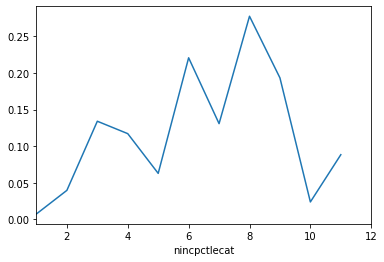

In [25]:
# Saving distinguishes people with positive networths from negative networths most 
# in the middle incomes, and is not as predictive for the poorest and richest. 
t = dfs.groupby(['nincpctlecat', dfs.networth > 0]).saved.mean().unstack()
t = t[True] - t[False]
t.plot()


In [26]:
dfs.debt2inc.describe()

count    100000.000000
mean          1.238745
std           2.753236
min           0.000000
25%           0.009085
50%           0.498922
75%           1.659036
max         149.326097
Name: debt2inc, dtype: float64

In [27]:
# Transfers have maybe 10% effect on debt
dfs.groupby([dfs.gi_sum > 0]).debt.mean()

gi_sum
False     94370.455842
True     106814.713801
Name: debt, dtype: float64

In [28]:
# Families that have recieved transfers have assets twice as large
t = dfs[dfs.age_1 < 45].copy()
t = t.groupby(['race',t.gi_sum > 0]).asset.median().unstack()
t['diff'] = t[True] - t[False]
t

gi_sum,False,True,diff
race,,,
black,17850.0,92500.0,74650.0
hisp,26510.0,439810.0,413300.0
other,59800.0,382200.0,322400.0
white,112360.0,205400.0,93040.0


In [29]:
# But the also have larger incomes
t = dfs[dfs.age_1 < 45].copy()
t = t.groupby(['race',t.gi_sum > 0]).norminc.median().unstack()
t['diff'] = t[True] - t[False]
t

gi_sum,False,True,diff
race,,,
black,37467.547387,54682.366456,17214.819070
hisp,40505.456634,52657.093624,12151.636990
other,50631.820793,57720.275704,7088.454911
white,60758.184951,70884.549110,10126.364159


In [30]:
# Whites and blacks hold similar amounts of debt, and debt to income, 
# across income ranges. 
dfs.groupby(['nincpctlecat', 'race']).mean()[['debt','debt2inc']].unstack()

debt                                              \
race                  black          hisp          other          white   
nincpctlecat                                                              
1               7682.984234  7.246642e+03   21138.780488   17079.166667   
2              14482.427895  1.832176e+04   36343.058511   17432.702928   
3              30707.000912  2.346919e+04   26792.238806   33828.236099   
4              35571.723381  4.231067e+04   46083.906250   35082.328645   
5              50699.222066  6.258824e+04   64156.549118   47974.714487   
6              70444.832962  9.908376e+04  109841.648352   70405.471481   
7              81902.176724  1.012750e+05  147124.324324   96980.815502   
8             106753.286999  1.300321e+05  100706.141176  119101.012525   
9             165196.247312  1.596139e+05  222290.525830  178554.387807   
10            220159.541485  2.076373e+05  315455.846561  267724.342262   
11            305447.592593  2.892147e+05  426375.613014  364516.189991   
12            412498.235294  1.339821e+06  840615.384615  724753.049494   

              debt2inc                                
race             black      hisp     other     white  
nincpctlecat                                          
1             0.725297  0.558351  4.179371  1.604524  
2             0.791980  0.841364  1.827013  1.144142  
3             1.107839  0.853220  0.954548  1.277473  
4             1.046953  1.091192  1.292943  1.033703  
5             1.073218  1.312487  1.216190  1.047828  
6             1.305931  1.589956  2.043071  1.363417  
7             1.079589  1.641994  1.956210  1.323400  
8             1.328568  1.330881  1.294926  1.254779  
9             1.229579  1.357524  1.655540  1.364760  
10            2.446749  1.185825  1.564559  1.408514  
11            0.937050  1.329223  1.262901  1.149427  
12            0.344474  4.761216  0.648064  0.499568

In [31]:
t = dfs[
    (dfs.age_1 < 50) & (dfs.age_1 > 40 ) & (dfs.homeeq > 0) 
]

t = t.groupby(['race','nincpctlecat']).asset.mean().unstack().T
t.columns = list(t.columns)
t['r'] = t.black / t.white

t

,black,hisp,other,white,r
nincpctlecat,,,,,
1,1.800100e+05,6.425750e+04,6.537476e+04,9.460733e+05,0.190271
2,6.025000e+04,1.285678e+05,NaN,6.795762e+04,0.886582
3,1.447528e+05,1.676473e+05,NaN,1.249799e+05,1.158208
4,1.043297e+05,1.986206e+05,4.437547e+05,1.773086e+05,0.588408
5,2.644727e+05,2.357434e+05,6.964850e+05,1.653942e+05,1.599045
6,1.738306e+05,2.740784e+05,2.381130e+05,2.922222e+05,0.594858
7,2.842195e+05,3.651517e+05,4.044368e+05,3.821094e+05,0.743817
8,3.278654e+05,3.496011e+05,1.075005e+06,4.352870e+05,0.753217
9,5.734933e+05,6.687949e+05,1.075097e+06,7.280645e+05,0.787696
